In [ ]:
import pickle
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
from joblib import Parallel,delayed

In [ ]:
path = '../data/data_emas_all_duration_day.p'
data1 = pickle.load(open(path,'rb'))

In [ ]:
import numpy as np
import pylab as pb
import GPy 
%pylab inline
def get_predictions(X,Y,error):
    X = (X - np.mean(X))/np.std(X)
    mm = np.mean(Y)
    ss = np.std(Y)
    Y = (Y-np.mean(Y))/ss
    kern =  GPy.kern.RBF(input_dim=1)
    Y_meta = {'output_index':np.arange(len(Y))[:,None]}
    m = GPy.models.GPHeteroscedasticRegression(X[:,None],Y[:,None],kern,Y_metadata=Y_meta)
    m['.*het_Gauss.variance'] = np.abs(error)[:,None] #Set the noise parameters to the error in Y
    m.het_Gauss.variance.fix() #We can fix the noise term, since we already know it
    m.optimize()
    preds,varss  = m.predict(m.X,full_cov=False,Y_metadata=None,kern=None,likelihood=None,include_likelihood=False)
    return preds*ss+mm,varss



def get_data(data):
    final_data = []
    df = pd.DataFrame({'duration':data[0],'data':data[1],'ema':data[2],'user':data[3],'hand':data[4]})

    from scipy.stats import iqr
    def get_weighted_rr_features(a):
        f = np.percentile(a[:len(a)//2,0],80)/np.percentile(a[(len(a)//2):,0],80)
        a = np.repeat(a[:,0],np.int64(np.round(100*a[:,1])))
        return np.array([np.var(a),iqr(a),np.mean(a),np.median(a),np.percentile(a,80),
                         np.percentile(a,20),np.max(a),skew(a),kurtosis(a),a[0],a[-1],a[len(a)//2]])
    
#     def get_feature1(a):
# #         try:
#         a = a[['time','stress_likelihood_ppg_qual','quality_mag']].dropna()
#         if a.shape[0]<5:
#             return np.nan
#         preds = get_predictions(a['time'].values,a['stress_likelihood_ppg_qual'].values,(1-a['quality_mag'].values)/6)
#         a['stress_likelihood_ppg_qual_final'] = preds[0]
#         plt.plot(a['time'],preds[0])
#         plt.show()
#         return a
#         except:
#             return np.nan
    
    def get_feature(a):
        try:
#             print(a.columns)
            a = a[['stress_likelihood_ppg_qual','quality_mag']].dropna().values
            
            return get_weighted_rr_features(a)
        except:
            return np.nan
    
    
    def get_quality(a):
        try:
            a = a['quality_mag'].dropna().values
            return np.percentile(a,80)
        except:
            return np.nan

    for i,data2 in list(df.groupby('user',as_index=False)):
#         print(data2.ema.iloc[0])
#         data2['feature'] = data2['data'].apply(lambda a:get_feature1(a))
#         data2 = data2.dropna()
        data2['feature'] = data2['data'].apply(lambda a:get_feature(a))
        data2['score'] = data2['ema'].apply(lambda a:a['score'])
        data2['label'] = data2['ema'].apply(lambda a:a['label'])
        data2['probs_mean'] = data2['data'].apply(lambda a:np.mean(a['probs']))
        data2['probs_80'] = data2['data'].apply(lambda a:np.percentile(a['probs'],80))
        data2['probs_20'] = data2['data'].apply(lambda a:np.percentile(a['probs'],20))
        
#         data2['happy'] = data2['ema'].apply(lambda a:a['all_scores'][0])
#         data2['joyful'] = data2['ema'].apply(lambda a:a['all_scores'][1])
#         data2['nervous'] = data2['ema'].apply(lambda a:a['all_scores'][2])
#         data2['sad'] = data2['ema'].apply(lambda a:a['all_scores'][3])
#         data2['angry'] = data2['ema'].apply(lambda a:a['all_scores'][4])
#         labels = data2[['happy','joyful','nervous','sad','angry']].values
#         for j in range(labels.shape[1]):
#             t = labels[:,j]
#             t[t<=np.mean(t)] = 0
#             t[t!=0] = 1
#             labels[:,j] = t
#         labels = np.sum(labels,axis=1)
#         labels[labels<=2] = 0
#         labels[labels!=0] = 1
#         data2['label'] = labels
        print(data2['label'].values)
        data2['quality'] = data2['data'].apply(lambda a:get_quality(a))
        data2 = data2[['duration','user','quality','hand','feature','score',
                       'label','data','probs_mean','probs_80','probs_20']].dropna()
        print(data2.head())
        final_data.append(data2)
    return final_data
        
output = Parallel(n_jobs=30,verbose=3)(delayed(get_data)(data) for data in data1)
# output = [get_data(data) for data in data1[:1]]
final_data = []
for r in output:
    final_data.extend(r)
#     print(data['feature'])
# data['ema'].loc[547]

In [ ]:
data = pd.concat(final_data)
def get_labels(df):
    df = df.dropna().sort_values('score').reset_index(drop=True)
    if df.shape[0]<10:
        return pd.DataFrame([],columns=df.columns)
    if np.sum(df['label'])<3:
        return pd.DataFrame([],columns=df.columns)
    if len(np.unique(df['label'].values))<2:
        return pd.DataFrame([],columns=df.columns)
    return df
data_global = data.groupby(['user','duration'],as_index=False).apply(get_labels)

In [ ]:
data = data_global

In [ ]:
for i in range(len(names)):
    data[names[i]] = data['feature'].apply(lambda a:a[i])

In [ ]:
pickle.dump(data,open('temp.p','wb'))

In [ ]:
import pickle
data = pickle.load(open('temp.p','rb'))

In [ ]:
# import sklearn
from sklearn.metrics import SCORERS
SCORERS.keys()
# data1 = data[data.duration==115].reset_index(drop=True)
# data.groupby('duration').count()

In [ ]:
names = ['var','iqr','mean','median','80','20']
import warnings
import pandas as pd
from copy import deepcopy
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import make_scorer
from sklearn.decomposition import PCA
from pprint import pprint
from sklearn.metrics import f1_score
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix,f1_score,precision_score,roc_auc_score,recall_score,accuracy_score,auc,classification_report,make_scorer,roc_curve,precision_recall_curve
import itertools
from sklearn.model_selection import ParameterGrid, cross_val_predict, GroupKFold,GridSearchCV, StratifiedKFold
from sklearn import preprocessing,metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from scipy.stats import pearsonr
from joblib import Parallel,delayed
import numpy as np
warnings.filterwarnings('ignore')
def f1Bias_scorer_CV(probs, y, ret_bias=False):

    precision, recall, thresholds = precision_recall_curve(y, probs)

    f1 = 0.0
    for i in range(0, len(thresholds)):
        if not (precision[i] == 0 and recall[i] == 0):
            f = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])
            if f > f1:
                f1 = f
                bias = thresholds[i]

    if ret_bias:
        return f1, bias
    else:
        return f1

def f1Bias_scorer_CV_2(probs, y, ret_bias=False):
    fpr, tpr, thresholds = roc_curve(y, probs)
    f1 = 0.0
    bias = 0
    for i in range(0, len(thresholds)):
        temp_y_pred = deepcopy(y)
        temp_y_pred[temp_y_pred>thresholds[i]] = 1
        temp_y_pred[temp_y_pred<=thresholds[i]] = 0
        f = f1_score(y,np.int32(temp_y_pred))
        if f > f1:
            f1 = f
            bias = thresholds[i]

    if ret_bias:
        return f1, bias
    else:
        return f1

def get_classification_report(X,y,n):
    my_score = make_scorer(my_score_auc,needs_threshold=True)
    paramGrid = {
            'rf__C': np.logspace(-3,3,40),
            'rf__class_weight':[{0:1,1:4/2},{0:1,1:3/2},{0:1,1:5/2},{0:1,1:1}],
            'rf__solver': ['lbfgs'],
#             'pca__n_components':[1,2,3,4,5]
    }
    clf = Pipeline([('rf',LogisticRegression())])
    grid_search = GridSearchCV(clf, paramGrid, n_jobs=-1,cv=StratifiedKFold(n_splits=n).split(X, y),
                               scoring=my_score,verbose=1, return_train_score=False)
    grid_search.fit(X,y)
    clf = grid_search.best_estimator_
    probs = cross_val_predict(clf,X,y,cv=StratifiedKFold(n_splits=n).split(X, y),n_jobs=5,method='predict_proba')[:,1]
    pp = deepcopy(probs)
    a,b = f1Bias_scorer_CV(probs, y, ret_bias=True)
    roc = roc_auc_score(y,probs)
    probs[probs>=b] = 1
    probs[probs<b] = 0
    y_pred = probs
    print(confusion_matrix(y,y_pred),classification_report(y,y_pred))
    return a,roc,pearsonr(y,y_pred)[0],confusion_matrix(y,y_pred),y,y_pred 

# def get_classification_report(X,y,n):
#     my_score = make_scorer(my_score_auc,needs_threshold=True)
#     paramGrid = ParameterGrid({
#             'rf__C': np.logspace(-3,3,10),
#             'rf__class_weight':[{0:1,1:4/2},{0:1,1:3/2},{0:1,1:5/2},{0:1,1:1}],
#             'rf__solver': ['lbfgs'],
#             'pca__n_components':[1,2,3,4,5]
#         })
#     clf = Pipeline([('pca',PCA()),('rf',LogisticRegression())])
#     all_f1,all_auc,all_corr = [],[],[]
#     for params in paramGrid:
#         f1 = []
#         auc = []
#         pearsonrr = []
#         clf.set_params(**params)
#         for train_index,test_index in StratifiedKFold(n_splits=n).split(X, y):
#             X_train,X_test = X[train_index],X[test_index]
#             y_train,y_test = y[train_index],y[test_index]
#             clf.fit(X_train,y_train)
#             y_pred = clf.predict_proba(X_test)[:,1]
#             f1.append(f1_score(y_test,clf.predict(X_test)))
#             auc.append(my_score_auc(y_test,y_pred))
#             pearsonrr.append(pearsonr(y_test,y_pred)[0])
#         all_f1.append(np.mean(f1))
#         all_auc.append(np.mean(auc))
#         all_corr.append(np.mean(pearsonrr))
#     ind_max = np.argmax(all_auc)
#     return all_f1[ind_max],all_auc[ind_max],all_corr[ind_max]

def my_score_auc(y_true,y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    return auc(fpr,tpr)

def get_data_again(df):
    data_all = []
    df = df.dropna().sort_values('score').reset_index(drop=True)
    if df.shape[0]<10:
        return []
    if df.label.sum()<3:
        return []
    if df.shape[0] - df.label.sum()<3:
        return []
    if len(np.unique(df['label'].values))<2:
        return []
    user = df['user'].values[0]
#     print(df.shape,df.columns,df['label'].unique())
    X = np.array(list(df['feature']))
    y = np.int64(np.array(list(df['label'])))
    print(X.shape,y.shape,np.sum(y))
    prob_mean = np.array(df['probs_mean'])
    prob_80 = np.array(df['probs_80'])
    prob_20 = np.array(df['probs_20'])
    n = 3
#     for train,test in StratifiedKFold(n_splits=n).split(X, y):
#         print(train.shape,np.sum(y[train]),test.shape,np.sum(y[test]),df['duration'].values[0],df['user'].values[0])
# #     try:
    f1_all,auc_all,p_all,conf_matrix,y,y_pred = get_classification_report(X,np.int64(y),n)
    prob_df = pd.DataFrame({"mean":prob_mean,'80':prob_80,'20':prob_20,
                                   'y':y,'y_pred':y_pred})
#     print(prob_df)
#     except:
#         return []
#     f1Bias_scorer_CV(df[name].values,df['label'].values),
    for k,name in enumerate(names):
        prob_df1 = pd.DataFrame({"mean":prob_mean,'80':prob_80,'20':prob_20,
                               'y':df['label'].values,'y_pred':df[name].values})
#         print(df[name].values,df['label'].values)
        data_all.append([user,name,df['duration'].values[0],
                         roc_auc_score(df['label'].values.astype(int),df[name].values.astype(float)),
                         roc_auc_score(df['label'].values.astype(int),df[name].values.astype(float)),
                         pearsonr(df[name].values,df['score'].values)[0],prob_df1])
    data_all.append([user,'Logistic Regression',df['duration'].values[0],
                         auc_all,
                         auc_all,
                         p_all,
                        prob_df])
    return data_all
# for duration in [75]:
#     try:
#         data1 = data[data.duration==duration].reset_index(drop=True)
output = Parallel(n_jobs=-1,verbose=3)(delayed(get_data_again)(df) for i,df in list(data.groupby(['duration','user'],as_index=False)))
#     except:
#         print(duration)
# output = [get_data_again(df) for i,df in list(data.groupby(['duration','user'],as_index=False))]
data_all = []
for r in output:
    data_all.extend(r)

In [ ]:
import os
# len(os.listdir('../../cc3/rice_data/after_ema_parsing/ecg_ppg_final_weighted_day_5/')),
data.duration.unique()

In [ ]:
import seaborn as sns
df = pd.DataFrame(data_all,columns=['user','feature','window_size','auc','f1','corr','probs'])

In [ ]:
pickle.dump(df,open('data_v1.p','wb'))

In [158]:
import pickle
import numpy as np
import pandas as pd
df = pickle.load(open('data.p','rb'))
logit = df[(df.feature=='80')]
# df.feature.unique()
logit.shape

(668, 7)

In [159]:
import warnings
warnings.filterwarnings('ignore')
def get_data(df):
    all_rows = []
    for i,row in df.iterrows():
        for j,row1 in row['probs'].iterrows():
            all_rows.append([row['user'],row['window_size'],row['auc'],row['f1'],row['corr'],
                            row1['mean'],row1['80'],row1['20'],row1['y'],row1['y_pred']])
    return pd.DataFrame(all_rows,columns=['user','window_size','auc','f1','corr','mean','80','20','y','y_pred'])

logit_data = logit.groupby('window_size',as_index=False).apply(get_data)
print(logit_data.shape)
df1 = logit_data
df1['y'] = np.int64(df1['y'].values)
df1['y_pred'] = np.float64(df1['y_pred'].values)
df1['indicator'] = 1
df1['indicator'][(df1.y==0)&(df1.y_pred==0)] = 'Not Stress - Not Stress'
df1['indicator'][(df1.y==0)&(df1.y_pred==1)] = 'Not Stress - Stress'
df1['indicator'][(df1.y==1)&(df1.y_pred==0)] = 'Stress - Not Stress'
df1['indicator'][(df1.y==1)&(df1.y_pred==1)] = 'Stress - Stress'
df1['mean_round'] = np.round((df1['80']*100)//10)/10
from sklearn.metrics import f1_score,roc_auc_score,accuracy_score,balanced_accuracy_score
from copy import deepcopy
def bacc(y,probs):
    acc = 0
    for threshold in np.arange(.01,.99,.05):
        temp = deepcopy(probs)
        temp[temp>=threshold] = 1
        temp[temp<threshold] = 0
        if balanced_accuracy_score(y,np.int64(temp))>acc:
            acc = balanced_accuracy_score(y,np.int64(temp))
    return acc
        
    
def merge_e(df):
    try:
#         if df.shape[0]<3:
#             return pd.DataFrame([],columns=['mean','window_size','roc_auc','balanced_accuracy','size','user'])
        df = df.reset_index(drop=True)
#         print(roc_auc_score(df['y'],df['y_pred']),
#                               balanced_accuracy_score(df['y'],df['y_pred']))
        return pd.DataFrame([[df['mean_round'].values[0],
                              df['window_size'].values[0],
                              roc_auc_score(df['y'],df['y_pred']),
                              bacc(df['y'],df['y_pred']),
                              roc_auc_score(df['y'],df['y_pred']),
                              int(df.shape[0]),
                              df['user'].values[0]]],
                        columns=['mean','window_size','roc_auc','balanced_accuracy','accuracy','size','user'])
    except:
        return pd.DataFrame([],columns=['mean','window_size','roc_auc','balanced_accuracy','accuracy','size','user'])
df2 = df1.groupby(['mean_round','window_size','user'],as_index=False).apply(merge_e)
# df2

(22094, 10)


In [161]:
df2['size'] = np.int64(df2['size'])
# df2.groupby(['window_size','mean']).mean()
df2

,,mean,window_size,roc_auc,balanced_accuracy,accuracy,size,user
39,0,0.2,5,1.000000,1.000000,1.000000,3,9744e4ae-63d8-49df-be6a-37cbb24532a1
78,0,0.3,5,0.000000,0.500000,0.000000,4,2197d640-d109-4f21-9691-7b009d4bfe4d
79,0,0.3,5,1.000000,1.000000,1.000000,2,34e42cf6-7c34-417c-a003-874e3b6151e7
80,0,0.3,5,1.000000,1.000000,1.000000,2,35109a64-411d-4768-9602-c0a3d519a088
162,0,0.4,5,0.437500,0.625000,0.437500,8,05846fcf-1dd9-4f98-b17b-1ce6e624c0a7
163,0,0.4,5,0.266667,0.583333,0.266667,11,2197d640-d109-4f21-9691-7b009d4bfe4d
164,0,0.4,5,0.000000,0.500000,0.000000,3,34e42cf6-7c34-417c-a003-874e3b6151e7
165,0,0.4,5,1.000000,1.000000,1.000000,5,35109a64-411d-4768-9602-c0a3d519a088
167,0,0.4,5,1.000000,1.000000,1.000000,2,4d20e373-f284-4975-8e6e-2bec5905f358
168,0,0.4,5,0.117647,0.500000,0.117647,20,522a66a7-1502-46fe-bce4-9e022c52219f


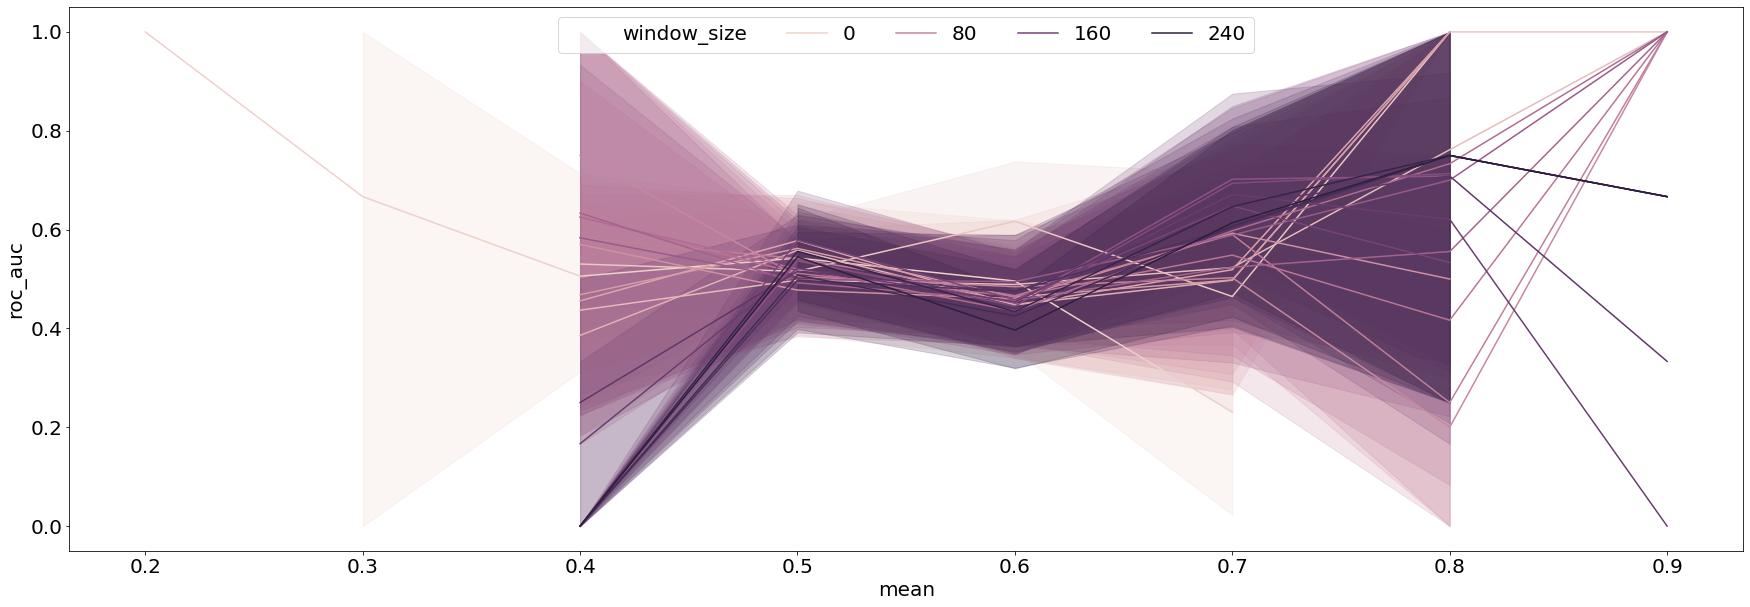

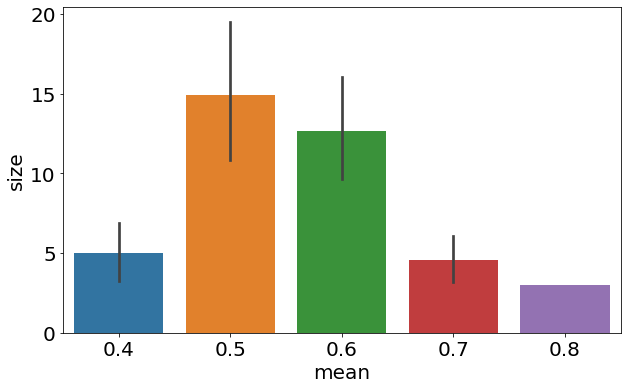

In [168]:
# print(df1.shape,df2.shape)
# %matplotlib inline
# import seaborn as sns
# import matplotlib.pyplot as plt
plt.figure(figsize=(30,10))
sns.lineplot(x='mean',y='roc_auc',hue='window_size',data=df2)
plt.legend(ncol=5)
plt.show()
# plt.figure(figsize=(10,6))
# sns.barplot(x='mean',y='balanced_accuracy',data=df2)
# plt.legend(ncol=5)
# plt.show()
# plt.figure(figsize=(10,6))
# sns.barplot(x='mean',y='accuracy',data=df2)
# plt.legend(ncol=5)
# plt.show()
plt.figure(figsize=(10,6))
sns.barplot(x='mean',y='size',data=df2[df2.window_size==35])
# plt.legend(ncol=7)
plt.show()
# plt.figure(figsize=(20,10))
# sns.boxplot(x='window_size',y='roc_auc',hue='mean',data=df2)
# plt.legend(ncol=5)
# plt.show()
# # plt.figure(figsize=(20,10))
# # sns.boxplot(x='window_size',y='roc_auc',hue='mean',data=df2[(df2.window_size>100)&(df2.window_size<150)])
# # plt.legend(ncol=5)
# # plt.show()
# # plt.figure(figsize=(20,10))
# # sns.boxplot(x='window_size',y='roc_auc',hue='mean',data=df2[(df2.window_size>0)&(df2.window_size<150)])
# # plt.legend(ncol=5)
# # plt.show()
# # plt.figure(figsize=(20,10))
# # sns.boxplot(x='window_size',y='roc_auc',hue='mean',data=df2[(df2.window_size>150)])
# # plt.legend(ncol=5)
# # plt.show()
# df1.groupby('mean_round').count()

In [57]:
df['user'].unique().shape
df1 = df.groupby(['feature','window_size'],as_index=False).median()

In [58]:
def get_max_auc(df):
    df = df.sort_values('auc').reset_index(drop=True)
    df = df.loc[df.shape[0]-1]
    return df

some_data = df1.groupby('feature',as_index=False).apply(get_max_auc)

In [59]:
tt = df1.groupby(['feature','window_size'],as_index=False).max().sort_values('auc').reset_index(drop=True)

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

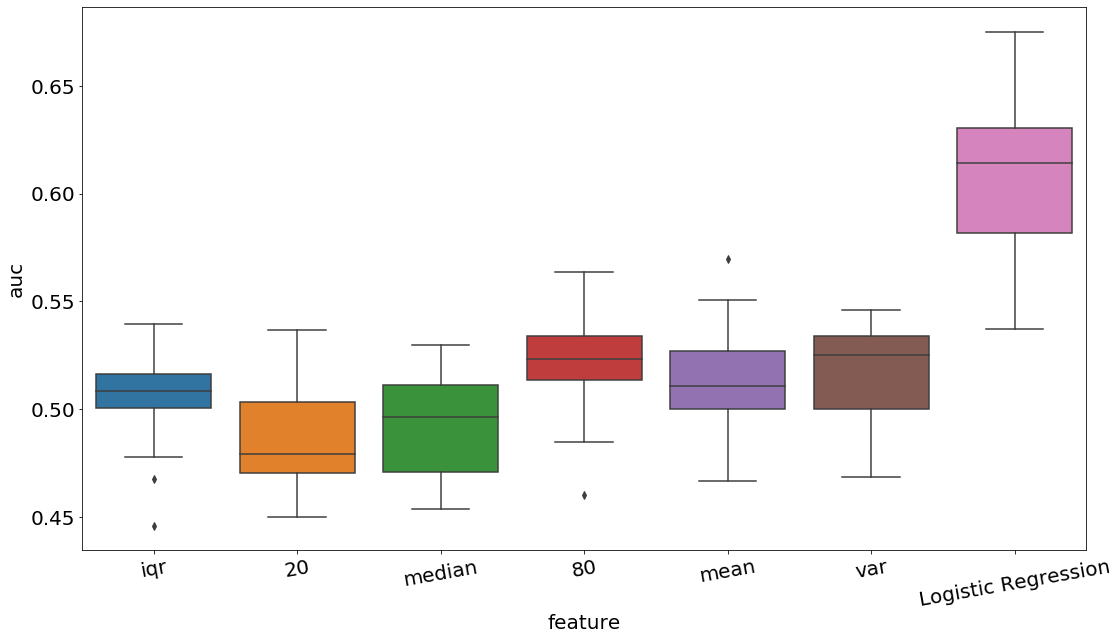

In [60]:
plt.figure(figsize=(18,10))
plt.rcParams.update({'font.size':20})
sns.boxplot(x='feature',y='auc',data=tt)
plt.xticks(rotation=10)

In [61]:
tt1 = tt[tt.feature=='Logistic Regression'].sort_values('auc').reset_index(drop=True)
tt1

,feature,window_size,auc,f1,corr
0,Logistic Regression,5,0.537281,0.537281,0.293134
1,Logistic Regression,55,0.554545,0.554545,0.269097
2,Logistic Regression,45,0.555556,0.555556,0.273321
3,Logistic Regression,35,0.562408,0.562408,0.277350
4,Logistic Regression,65,0.562981,0.562981,0.301097
5,Logistic Regression,75,0.580460,0.580460,0.419839
6,Logistic Regression,25,0.586026,0.586026,0.322490
7,Logistic Regression,15,0.592857,0.592857,0.304290
8,Logistic Regression,95,0.596757,0.596757,0.289298
9,Logistic Regression,145,0.602941,0.602941,0.407359


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]), <a list of 22 Text xticklabel objects>)

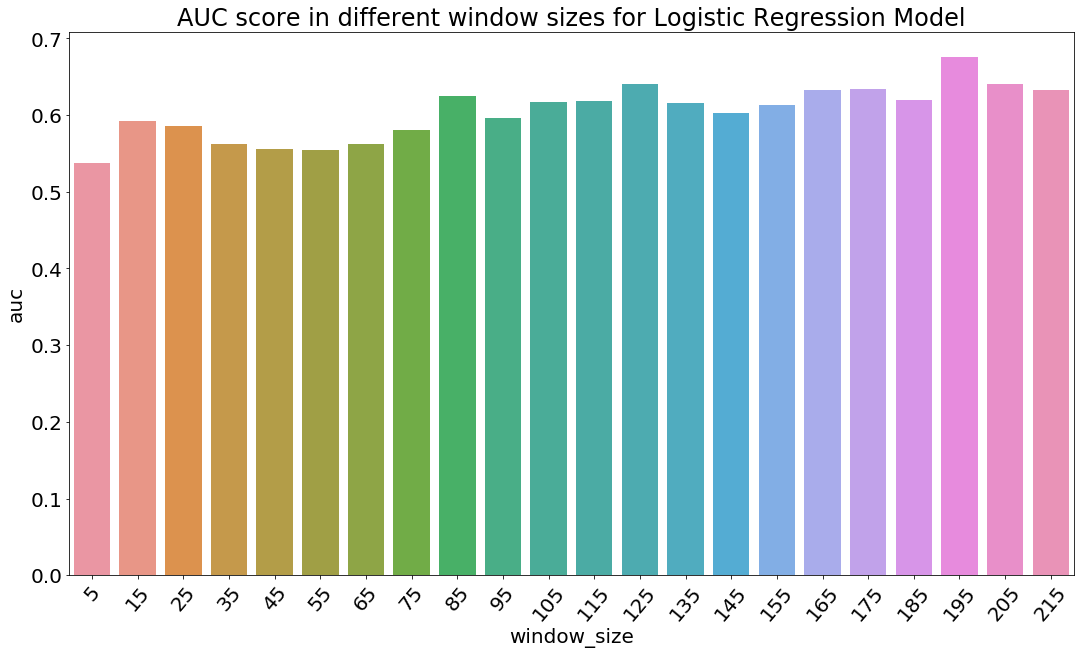

In [62]:
plt.figure(figsize=(18,10))
sns.barplot(x='window_size',y='auc',data=tt1)
plt.title('AUC score in different window sizes for Logistic Regression Model')
plt.xticks(rotation=50)

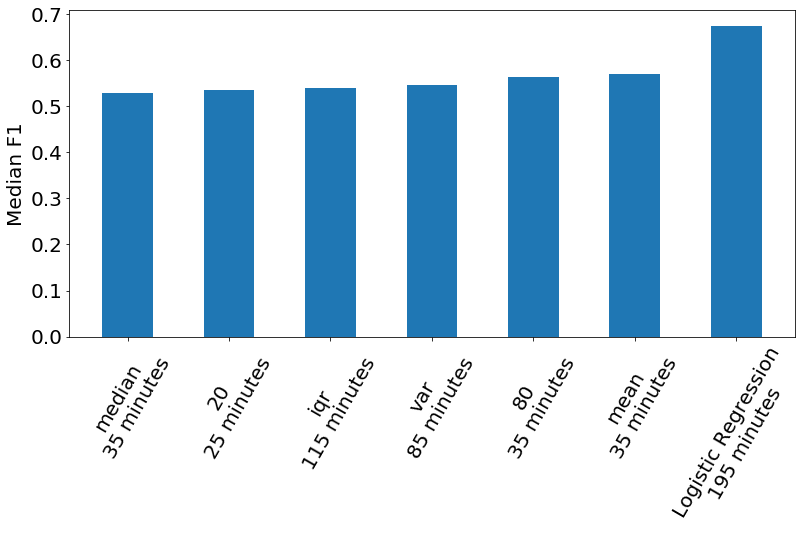

In [66]:
some_data = some_data.sort_values('auc').reset_index(drop=True)
plt.rcParams.update({'font.size':20})
plt.figure(figsize=(13,6))
plt.bar(some_data['feature'],some_data['auc'],.5)
plt.ylabel('Median F1')
plt.xticks(range(some_data.shape[0]),[row['feature']+'\n'+str(row['window_size'])+' minutes' for i,row in some_data.iterrows()],rotation=60)
plt.show()

([], <a list of 0 Text xticklabel objects>)

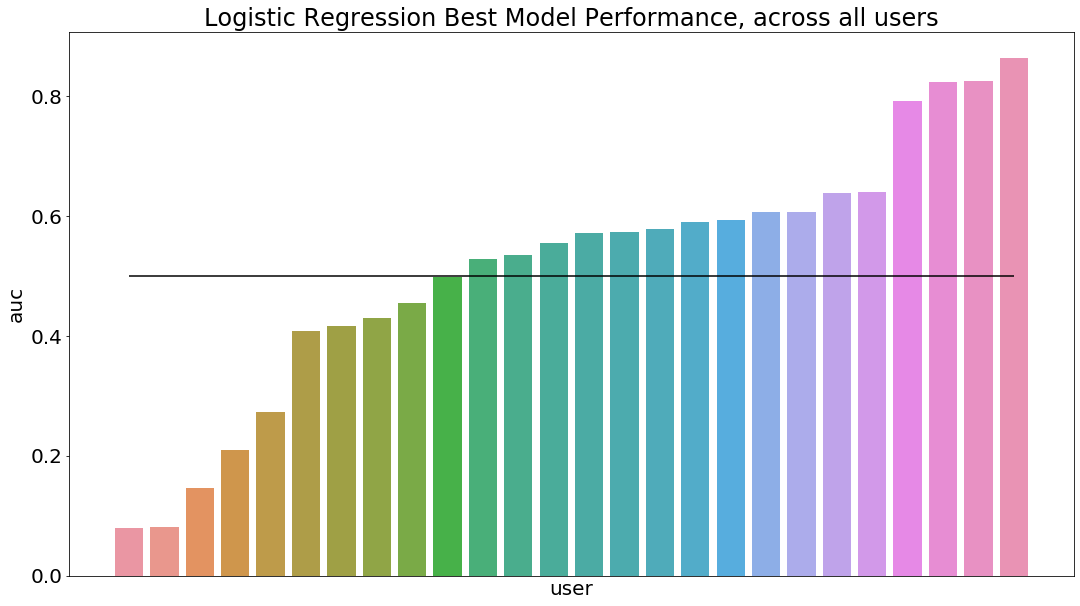

In [147]:
plt.figure(figsize=(18,10))
# df2['index'] = 
sns.barplot(x='user',y='auc',data=df[(df.feature=='80')&(df.window_size==35)].sort_values('auc'))
plt.hlines(.5,0,25)
# plt.hlines(.68,0,33,color='r')
plt.title('Logistic Regression Best Model Performance, across all users')
plt.xticks([])
# plt.legend(ncol=10)

In [18]:
df1[df1.feature=='Logistic Regression'].sort_values('auc')

,feature,window_size,auc,f1,corr
44,Logistic Regression,5,0.488918,0.488918,0.332153
50,Logistic Regression,65,0.534188,0.534188,0.286391
49,Logistic Regression,55,0.542484,0.542484,0.271448
48,Logistic Regression,45,0.552707,0.552707,0.340279
45,Logistic Regression,15,0.560091,0.560091,0.387298
47,Logistic Regression,35,0.572650,0.572650,0.333333
58,Logistic Regression,145,0.577358,0.577358,0.327327
46,Logistic Regression,25,0.578281,0.578281,0.387298
51,Logistic Regression,75,0.581837,0.581837,0.374634
62,Logistic Regression,185,0.587500,0.587500,0.412581


In [ ]:
import matplotlib.pyplot as plt
# df = df[df['window size']<20]
plt.figure(figsize=(18,10))
sns.boxplot(x="feature", y='auc', hue="window_size",
                 data=df, linewidth=2.5)
plt.legend(ncol=7)
plt.ylim([-.5,1])
# plt.hlines(.5,1,7)

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import RobustScaler
# from ecg import ecg_feature_computation
import matplotlib.pyplot as plt
# from hrvanalysis import get_time_domain_features,get_geometrical_features,get_csi_cvi_features,get_poincare_plot_features
# from hrvanalysis import get_frequency_domain_features
from typing import List
import numpy as np
import scipy.signal as signal
from copy import deepcopy
import datetime
import numpy as np
from scipy.stats import iqr
from enum import Enum
from sklearn.decomposition import PCA
from pprint import pprint
from sklearn.metrics import f1_score
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix,roc_auc_score,f1_score,roc_curve,auc,precision_score,recall_score,accuracy_score,classification_report,make_scorer,precision_recall_curve
import itertools
from sklearn.model_selection import ParameterGrid, cross_val_predict, GroupKFold,GridSearchCV
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from joblib import Parallel,delayed
from sklearn.preprocessing import StandardScaler

In [ ]:
def f1Bias_scorer_CV(probs, y, ret_bias=False):

    precision, recall, thresholds = precision_recall_curve(y, probs)

    f1 = 0.0
    for i in range(0, len(thresholds)):
        if not (precision[i] == 0 and recall[i] == 0) and precision[i]>recall[i]-.1:
            f = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])
            if f > f1:
                f1 = f
                bias = thresholds[i]

    if ret_bias:
        return f1, bias
    else:
        return f1

def my_score_auc(y_true,y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    return auc(fpr,tpr)    

def get_results(X,y,groups):
    my_score = make_scorer(my_score_auc,needs_threshold=True)
    delta = 0.1
    paramGrid = {'rf__kernel': ['rbf'],
                 'rf__C': [10,1,100,200],
                 'rf__gamma': [np.power(2,np.float(x)) for x in np.arange(-6, -2, .25)],
                 'rf__class_weight': [{0: w, 1: 1 - w} for w in [.2,.3,.25,.35]],
                 'rf__probability':[True]
    }
    pca = PCA(n_components=4)
    clf = Pipeline([('sts',StandardScaler()),('rf', SVC())])
    gkf = GroupKFold(n_splits=len(np.unique(groups)))
    grid_search = GridSearchCV(clf, paramGrid, n_jobs=-1,cv=list(gkf.split(X,y,groups=groups)),
                               scoring=my_score,verbose=5)
    grid_search.fit(X,y)
    clf = grid_search.best_estimator_
    probs = cross_val_predict(clf,X,y,cv=gkf.split(X,y,groups=groups),n_jobs=20,method='predict_proba')[:,1]
    pp = deepcopy(probs)
    a,b = f1Bias_scorer_CV(probs, y, ret_bias=True)
    print(roc_auc_score(y,probs),a,b,'rr')
    probs[probs>=b] = 1
    probs[probs<b] = 0
    y_pred = np.int64(probs)
    print(classification_report(y,y_pred),confusion_matrix(y,y_pred))
#     clf.fit(X,y)
    return np.array([f1_score(y,y_pred),roc_auc_score(y,y_pred),recall_score(y,y_pred)])

In [ ]:
def get_user_results(df):
    print(df['duration'].unique())
    qual = df['q'].values[0]
    groups = np.array(list(df['user']))
    X = np.array(list(df['feature']))
    y = np.array(list(df['label']))
    duration = df['duration'].values[0]
    print(duration,qual)
    arr = get_results(X,y,groups)
    return pd.DataFrame([[duration,qual,arr[0],arr[1],arr[2]]],columns=['duration','quality','f1','precision','recall'])

In [ ]:
import numpy as np
def get_results_qual(data_global,q):
    data_global1 = deepcopy(data_global[data_global.quality>=q]).reset_index(drop=True)
    print(data_global1['duration'].unique())
    print(data_global1.shape,data_global.shape)
    data_global1['q'] = q
    data_d = data_global1.groupby('duration',as_index=False).apply(get_user_results)
    return data_d
from joblib import Parallel,delayed
# all_data = Parallel(n_jobs=-1,verbose=3)(delayed(get_results_qual)(data_global,q) for q in np.arange(0,.5,.05))
all_data = [get_results_qual(data_global,q) for q in np.arange(0,.5,.05)]

In [ ]:
results = pd.concat(all_data)

In [ ]:
results.groupby('quality').max()